## Missing Values

In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno 
import matplotlib.pyplot as plt
import math
import holidays
import numpy as np
from scipy.stats import skew
from sklearn.impute import KNNImputer


In [2]:
df = pd.read_excel("../Data/gasoline_price_sentiment.xlsx", "data_combined")
df_before = pd.read_excel("../Data/gasoline_price_sentiment.xlsx", "data_combined")
del df["commodity"]
del df_before["commodity"]

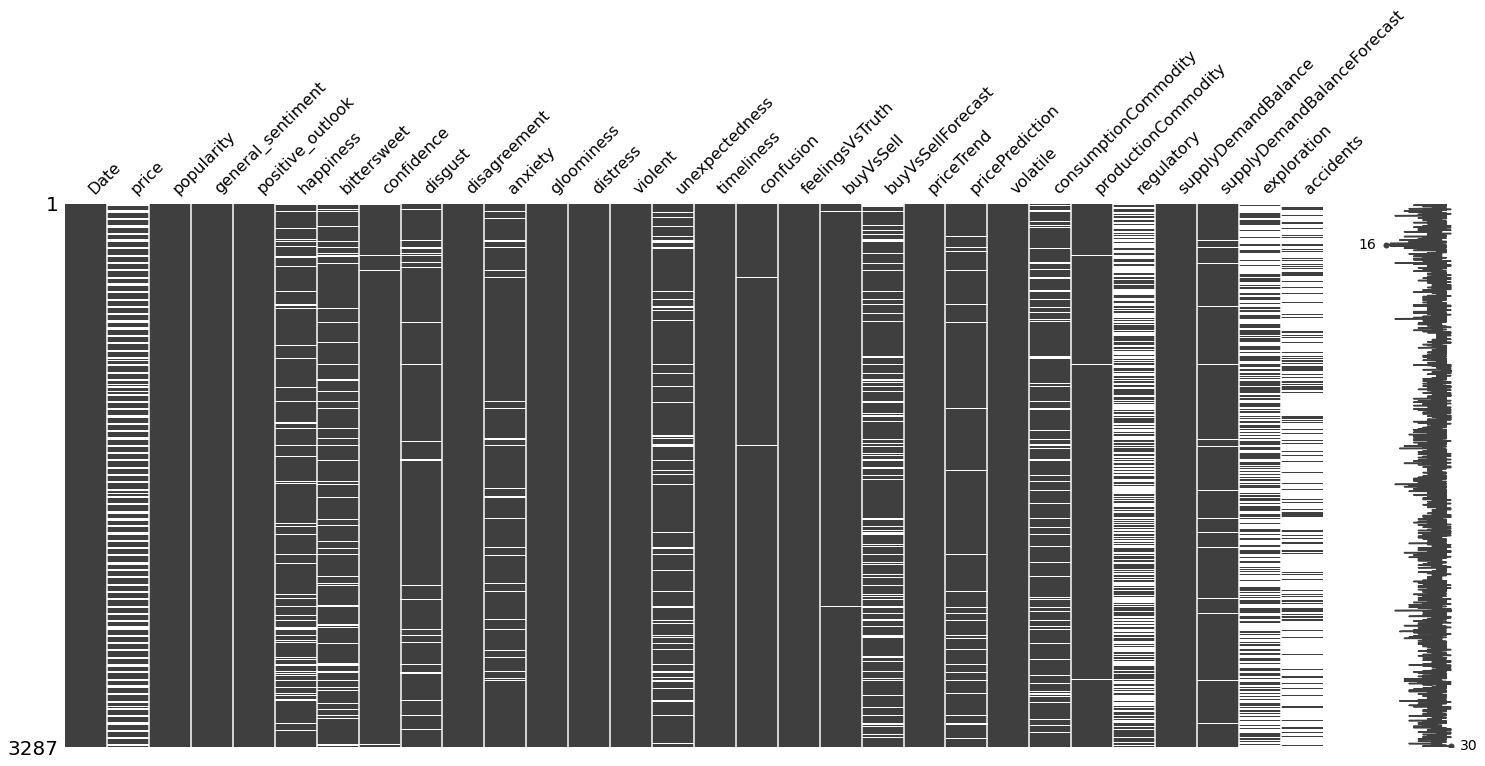

In [3]:
msno.matrix(df)
plt.show()

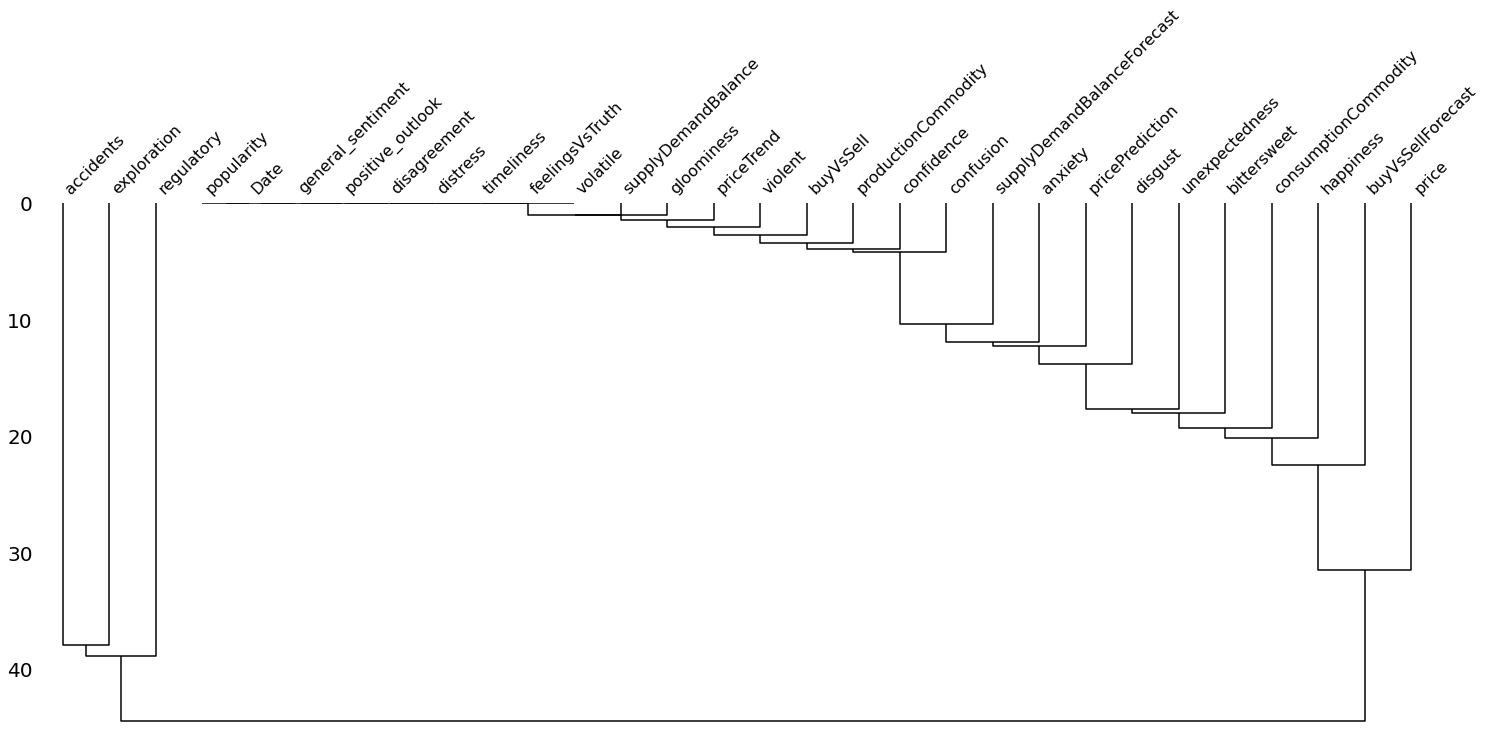

In [4]:
msno.dendrogram(df)
plt.show()

### Holiday and Price

In [5]:
National_Holiday_list=[]
for b in df.index:
    National_holidays = holidays.country_holidays('MY')
    HoldValue=National_holidays.get(df['Date'][b])


    if (HoldValue != None) :
        # print(HoldValue)
        National_Holiday_list.append((1))
    
    else:
        National_Holiday_list.append((0))


df['National_Holiday'] = National_Holiday_list
df['National_Holiday']

0       1
1       0
2       0
3       0
4       0
       ..
3282    0
3283    0
3284    0
3285    0
3286    0
Name: National_Holiday, Length: 3287, dtype: int64

In [6]:
Weekend=[]
for b in df.index:
    Date = df['Date'][b]
    if Date.weekday() > 4 :
        WeekendTrue = 1
    else :
        WeekendTrue = 0

    Weekend.append((WeekendTrue))

df['Weekend'] = Weekend

In [7]:
df['Holidays']  =df['Weekend'].astype(str) +df['National_Holiday'].astype(str)

In [8]:
ValueToReplace=['01','10','11']
for i in ValueToReplace:
    df['Holidays'].mask(df['Holidays'] == i, np.nan, inplace=True)

In [9]:
df['Holidays']

0       NaN
1       NaN
2       NaN
3        00
4        00
       ... 
3282     00
3283     00
3284    NaN
3285    NaN
3286     00
Name: Holidays, Length: 3287, dtype: object

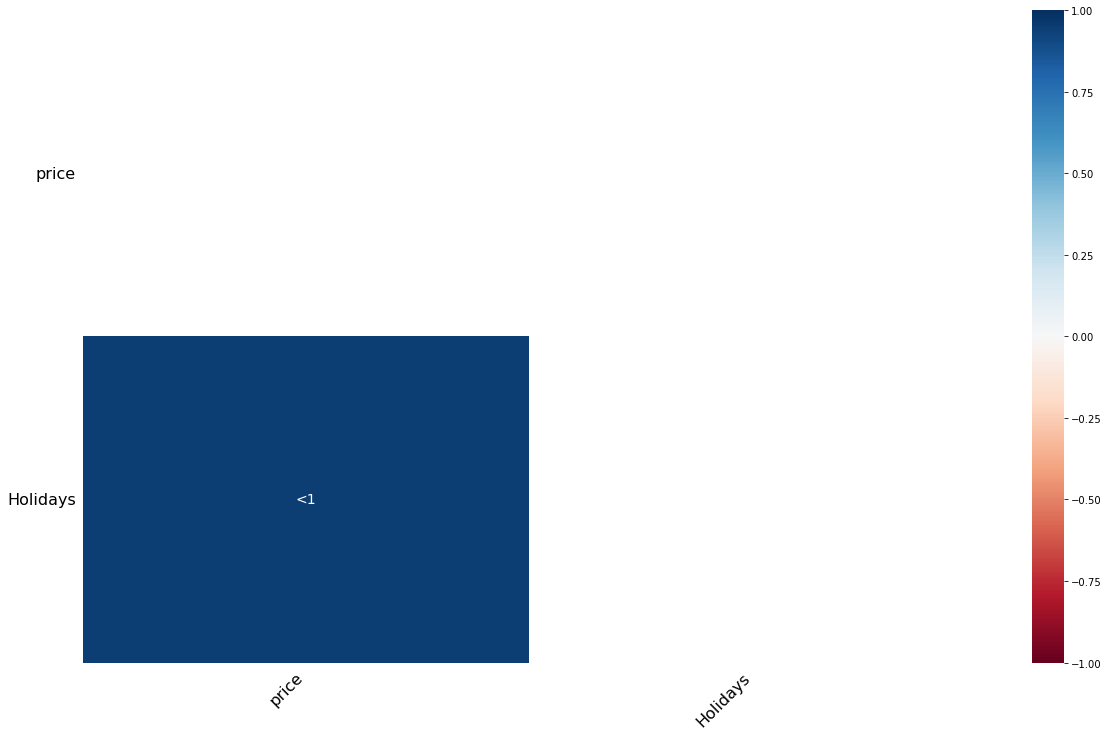

In [10]:
msno.heatmap(df[['price','Holidays']])
plt.show()

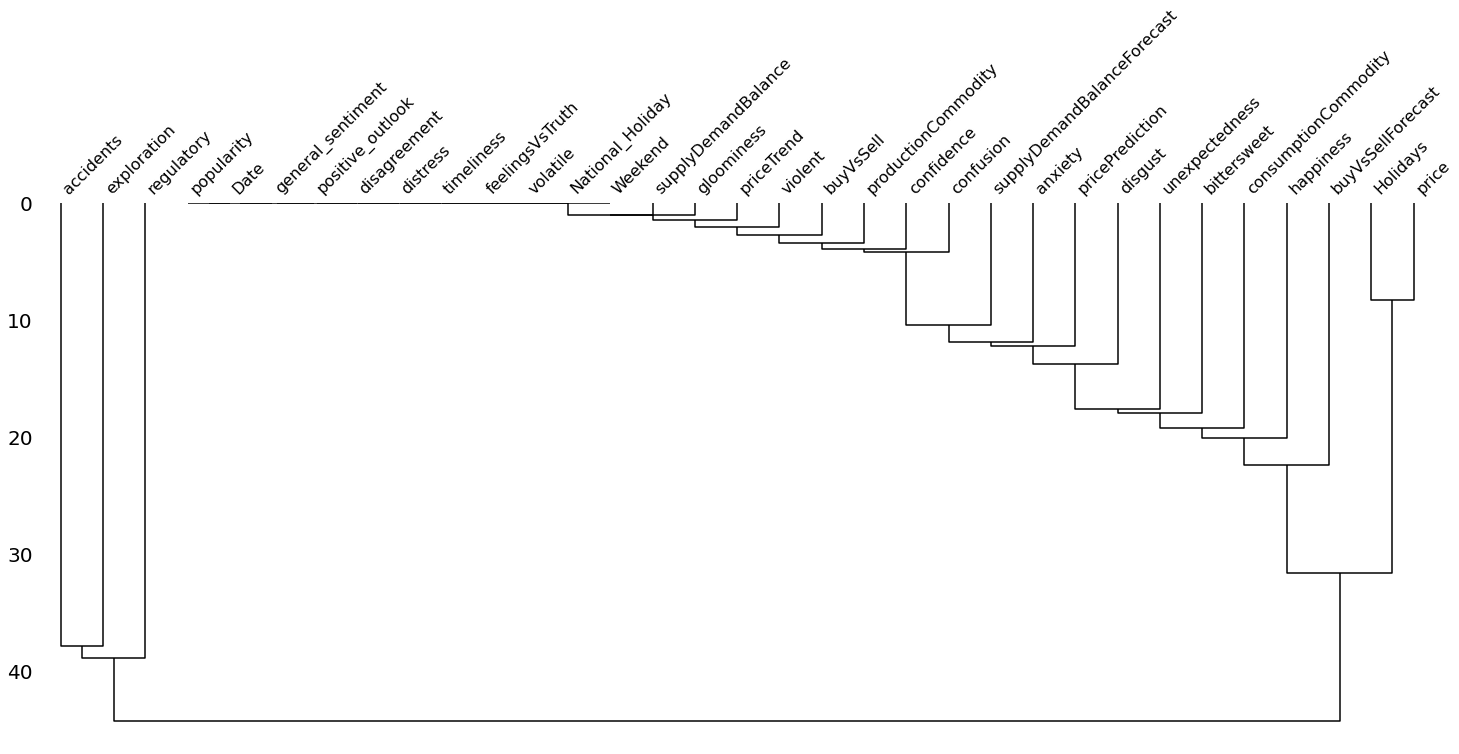

In [11]:
msno.dendrogram(df)
plt.show()

From the correlation metric above, we can see there is almost a 100% correlation between the missing values in price and when there is a holiday. The dendogram also shows similarity between the variable. In other words, <b>prices are missing on holidays</b>. 
- Hence, we can use forward fill and then back fill to impute all missing price values.

In [12]:
#Before treatment
df = df[:]
df["price_is_null"] = df["price"].isnull()
print("Missing values count:", len(df[df["price_is_null"] == True]))

Missing values count: 1035


In [13]:
#After treatment
df["price"].fillna(method ='ffill', inplace = True)
df["price_is_null"] = df["price"].isnull()
print("Missing values count:", len(df[df["price_is_null"] == True]))
del df["price_is_null"]

Missing values count: 3


In [14]:
df["price"].fillna(method="bfill", inplace=True)
df["price_is_null"] = df["price"].isnull()
print("Missing values count:", len(df[df["price_is_null"] == True]))
del df["price_is_null"]

Missing values count: 0


In [15]:
non_sentiment_columns = df[['price','buyVsSell', 'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'consumptionCommodity', 'productionCommodity', 'supplyDemandBalance', 'supplyDemandBalanceForecast']]

KNN_imputer = KNNImputer()


# # Impute and round the users DataFrame
ImputedNonSentimentKNN = KNN_imputer.fit_transform(non_sentiment_columns)

dfKNNImputed = pd.DataFrame(ImputedNonSentimentKNN, columns = ['price','buyVsSell', 'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'consumptionCommodity', 'productionCommodity', 'supplyDemandBalance', 'supplyDemandBalanceForecast'])


In [16]:
print(dfKNNImputed.head())

dfKNNImputed.isna().sum()

       price  buyVsSell  buyVsSellForecast  priceTrend  pricePrediction  \
0  87.240684  -0.017641           0.007425    0.000986         0.000006   
1  87.240684   0.000018           0.007425    0.000018         0.003485   
2  87.240684   0.026210           0.026210    0.013104         0.004367   
3  87.240684   0.002389          -0.000788    0.056395         0.013508   
4  88.983266  -0.002111          -0.001585    0.067871         0.010518   

   consumptionCommodity  productionCommodity  supplyDemandBalance  \
0             -0.007837             0.005888            -0.060778   
1              0.000018             0.005219            -0.020786   
2              0.008735             0.017473            -0.019661   
3              0.002786             0.006360             0.083796   
4             -0.001058             0.006834             0.037090   

   supplyDemandBalanceForecast  
0                     0.000006  
1                    -0.005183  
2                    -0.000002  
3 

price                          0
buyVsSell                      0
buyVsSellForecast              0
priceTrend                     0
pricePrediction                0
consumptionCommodity           0
productionCommodity            0
supplyDemandBalance            0
supplyDemandBalanceForecast    0
dtype: int64

In [17]:
for columnname in dfKNNImputed.columns:
    df[columnname] = dfKNNImputed[columnname]

In [18]:
df.isna().sum()

Date                              0
price                             0
popularity                        0
general_sentiment                 0
positive_outlook                  0
happiness                       379
bittersweet                     308
confidence                       14
disgust                         181
disagreement                      0
anxiety                         137
gloominess                        1
distress                          0
violent                           4
unexpectedness                  304
timeliness                        0
confusion                        16
feelingsVsTruth                   0
buyVsSell                         0
buyVsSellForecast                 0
priceTrend                        0
pricePrediction                   0
volatile                          0
consumptionCommodity              0
productionCommodity               0
regulatory                     1739
supplyDemandBalance               0
supplyDemandBalanceForecast 

### Exploration, Accidents, and Regulatory

In [19]:
df[['exploration', 'accidents','regulatory']]=df[['exploration', 'accidents','regulatory']].fillna(0)

### Holiday Imputations

As mentioned above NaN is a holiday, hence we would replace NaN with 1 and the rest with 0.

In [20]:
df['Holidays']=df['Holidays'].fillna(1)
df['Holidays'].mask(df['Holidays'] == 00, 0, inplace=True)

df.isna().sum()

Date                             0
price                            0
popularity                       0
general_sentiment                0
positive_outlook                 0
happiness                      379
bittersweet                    308
confidence                      14
disgust                        181
disagreement                     0
anxiety                        137
gloominess                       1
distress                         0
violent                          4
unexpectedness                 304
timeliness                       0
confusion                       16
feelingsVsTruth                  0
buyVsSell                        0
buyVsSellForecast                0
priceTrend                       0
pricePrediction                  0
volatile                         0
consumptionCommodity             0
productionCommodity              0
regulatory                       0
supplyDemandBalance              0
supplyDemandBalanceForecast      0
exploration         

### Sentiment Columns

Window of 7 (1 week)

In [21]:
df_7 = df.copy()
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_7[col].fillna(df_7[col].rolling(7, min_periods=1).mean(), inplace = True)

In [22]:
#First rows are not imputed... hence need to manually impute it
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_7[col].fillna(df_7[col].iloc[:7].mean(), inplace = True)

Window of 30 (1 month)

In [23]:
df_30 = df.copy()
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_30[col].fillna(df_30[col].rolling(30, min_periods=1).mean(), inplace = True)

In [24]:
#First rows are not imputed... hence need to manually impute it
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_30[col].fillna(df_30[col].iloc[:30].mean(), inplace = True)

Window of 365 (1 year)

In [25]:
df_365 = df.copy()
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_365[col].fillna(df_365[col].rolling(365, min_periods=1).mean(), inplace = True)

In [26]:
#First rows are not imputed... hence need to manually impute it
sentiment_columns = ['happiness', 'bittersweet', 'confidence', 'disgust', 'anxiety', 'gloominess', 'violent', 'unexpectedness', 'confusion', 'buyVsSellForecast']
for col in sentiment_columns:
    df_365[col].fillna(df_365[col].iloc[:365].mean(), inplace = True)

### Outcome of Missing Values Imputation

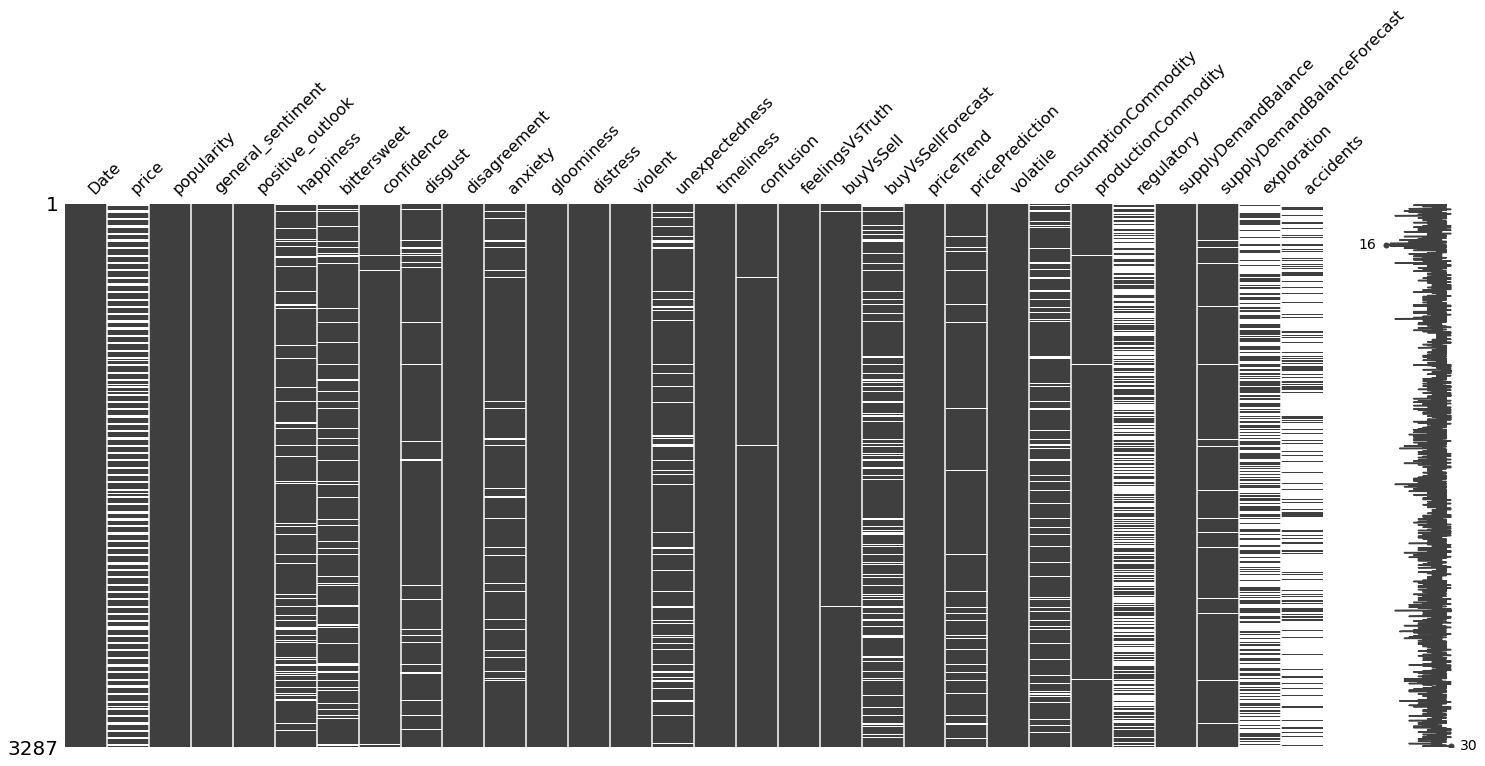

In [27]:
msno.matrix(df_before)
plt.show() 

In [28]:
df_before.isna().sum()

Date                              0
price                          1035
popularity                        0
general_sentiment                 0
positive_outlook                  0
happiness                       379
bittersweet                     308
confidence                       14
disgust                         181
disagreement                      0
anxiety                         137
gloominess                        1
distress                          0
violent                           4
unexpectedness                  304
timeliness                        0
confusion                        16
feelingsVsTruth                   0
buyVsSell                         7
buyVsSellForecast               478
priceTrend                        2
pricePrediction                 142
volatile                          0
consumptionCommodity            352
productionCommodity              11
regulatory                     1739
supplyDemandBalance               1
supplyDemandBalanceForecast 

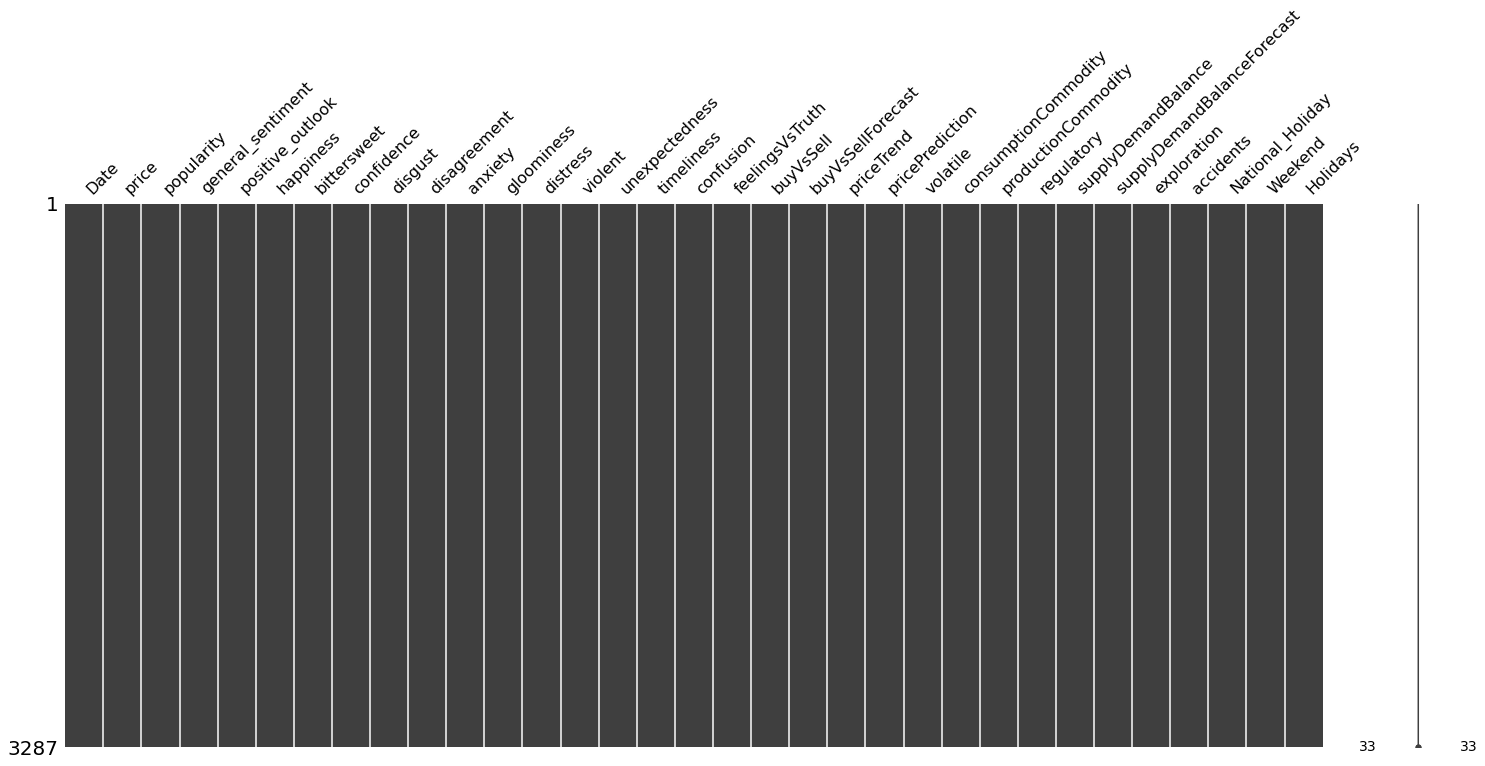

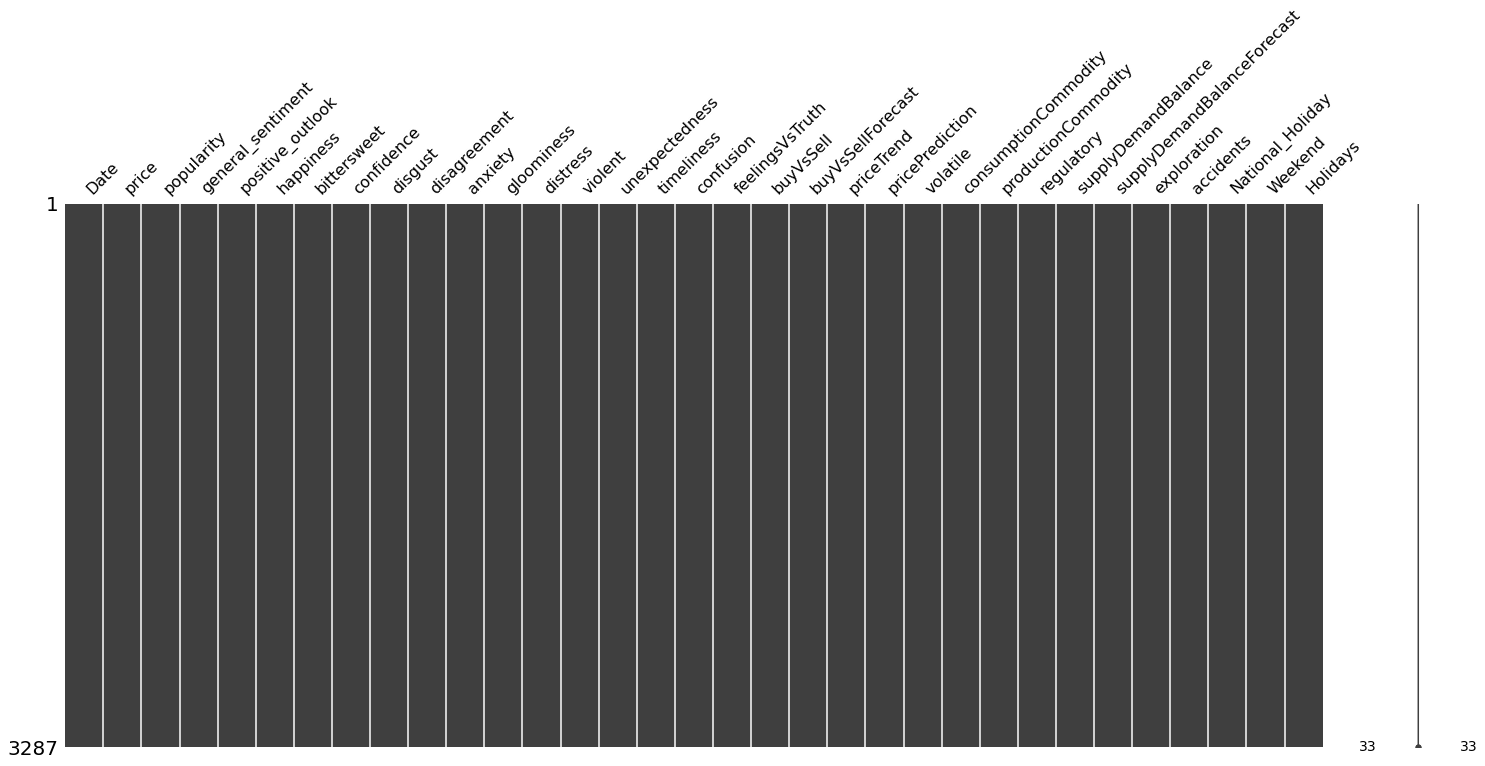

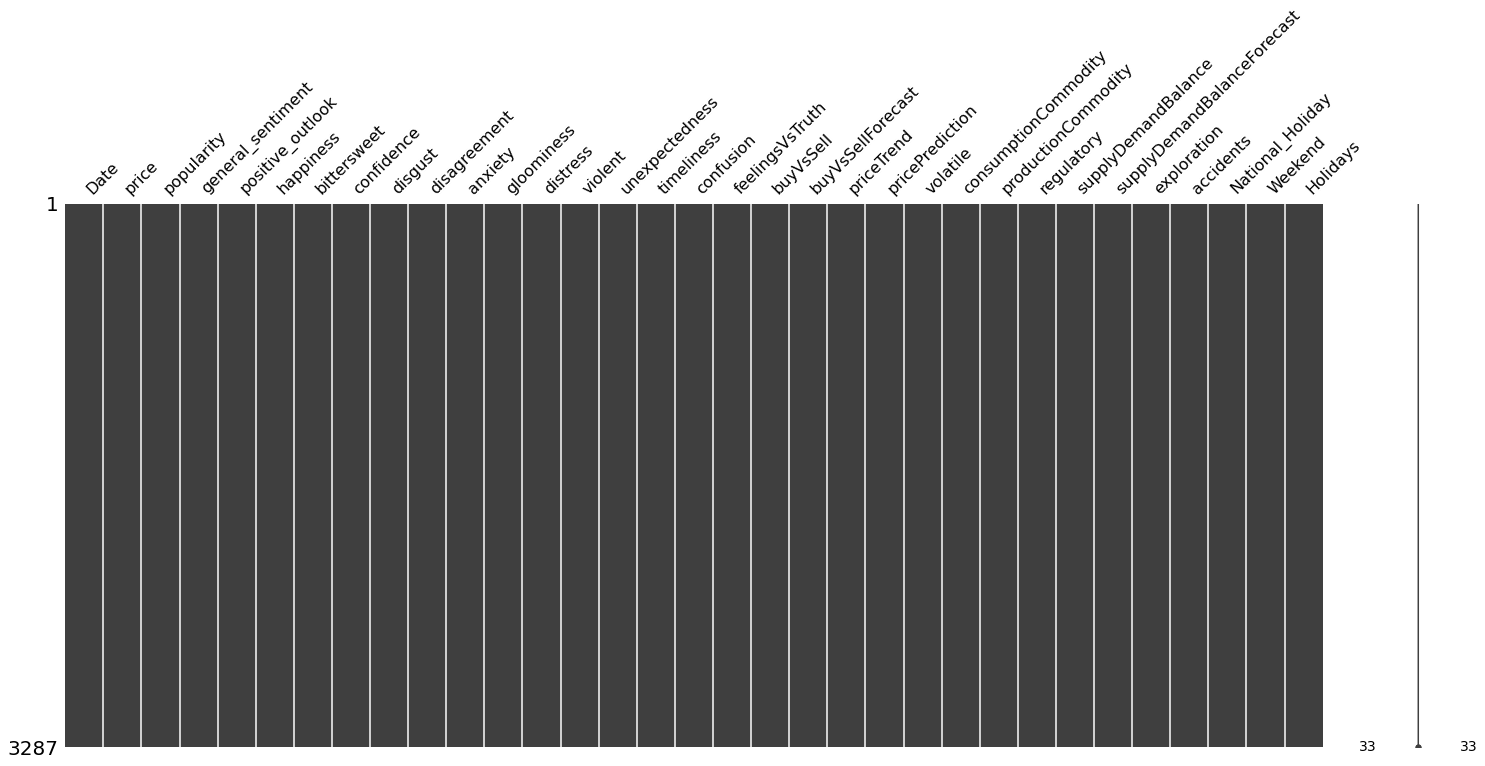

In [29]:
msno.matrix(df_7), msno.matrix(df_30), msno.matrix(df_365)
plt.show()

In [30]:
df_7.isna().sum(), df_30.isna().sum(), df_365.isna().sum()

(Date                           0
 price                          0
 popularity                     0
 general_sentiment              0
 positive_outlook               0
 happiness                      0
 bittersweet                    0
 confidence                     0
 disgust                        0
 disagreement                   0
 anxiety                        0
 gloominess                     0
 distress                       0
 violent                        0
 unexpectedness                 0
 timeliness                     0
 confusion                      0
 feelingsVsTruth                0
 buyVsSell                      0
 buyVsSellForecast              0
 priceTrend                     0
 pricePrediction                0
 volatile                       0
 consumptionCommodity           0
 productionCommodity            0
 regulatory                     0
 supplyDemandBalance            0
 supplyDemandBalanceForecast    0
 exploration                    0
 accidents    

Adding value 1 to each sentiment values

In [31]:
namesofsentiments= [ 'general_sentiment',
 'positive_outlook',
 'happiness',
 'bittersweet',
 'confidence',
 'disgust',
 'disagreement',
 'anxiety',
 'gloominess',
 'distress',
 'violent',
 'unexpectedness',
 'timeliness',
 'confusion',
 'feelingsVsTruth',
 'buyVsSell',
 'buyVsSellForecast',
 'priceTrend',
 'pricePrediction',
 'volatile',
 'consumptionCommodity',
 'productionCommodity',
 'regulatory',
 'supplyDemandBalance',
 'supplyDemandBalanceForecast',
 'exploration',
 'accidents']

for i in namesofsentiments:
    df_7[i]=df_7[i] + 1
    df_30[i] = df_30[i] + 1
    df_365[i] = df_365[i] + 1
    #df[i]=df[i].astype(dtype='float64')

## Variable Transformation

In [32]:
# Variable Transformation
def transformation (df, columns):

    for i in columns:

        OriginalSkew=skew(df[i])

        if OriginalSkew > 0.8 or OriginalSkew < -0.8:

            TLog=skew(np.log(df[i]))
            TSqrt=skew(np.sqrt(df[i]))

            if abs(TLog) < abs(TSqrt):

                Transformation="Log"
                Name="{}_".format(i) + Transformation

                df[Name] = np.log(df[i])

            elif abs(TSqrt) < abs(TLog):

                Transformation="sqrt"
                Name="{}_".format(i) + Transformation

                df[Name] = np.sqrt(df[i])

    return (df)

In [33]:
df_7 = transformation(df_7, namesofsentiments)
df_30 = transformation(df_30, namesofsentiments)
df_365 = transformation(df_365, namesofsentiments)

In [39]:
df_7.columns

Index(['Date', 'price', 'popularity', 'general_sentiment', 'positive_outlook',
       'happiness', 'bittersweet', 'confidence', 'disgust', 'disagreement',
       'anxiety', 'gloominess', 'distress', 'violent', 'unexpectedness',
       'timeliness', 'confusion', 'feelingsVsTruth', 'buyVsSell',
       'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'volatile',
       'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log'],
      dtype='object')

In [40]:
df_7sub = df_7.iloc[-17:]

price
popularity
general_sentiment
positive_outlook
happiness
bittersweet
confidence
disgust
disagreement
anxiety
gloominess
distress
violent
unexpectedness
timeliness
confusion
feelingsVsTruth
buyVsSell
buyVsSellForecast
priceTrend
pricePrediction
volatile
consumptionCommodity
productionCommodity
regulatory
supplyDemandBalance
supplyDemandBalanceForecast
exploration
accidents
National_Holiday
Weekend
Holidays


TypeError: Horizontal orientation requires numeric `x` variable.

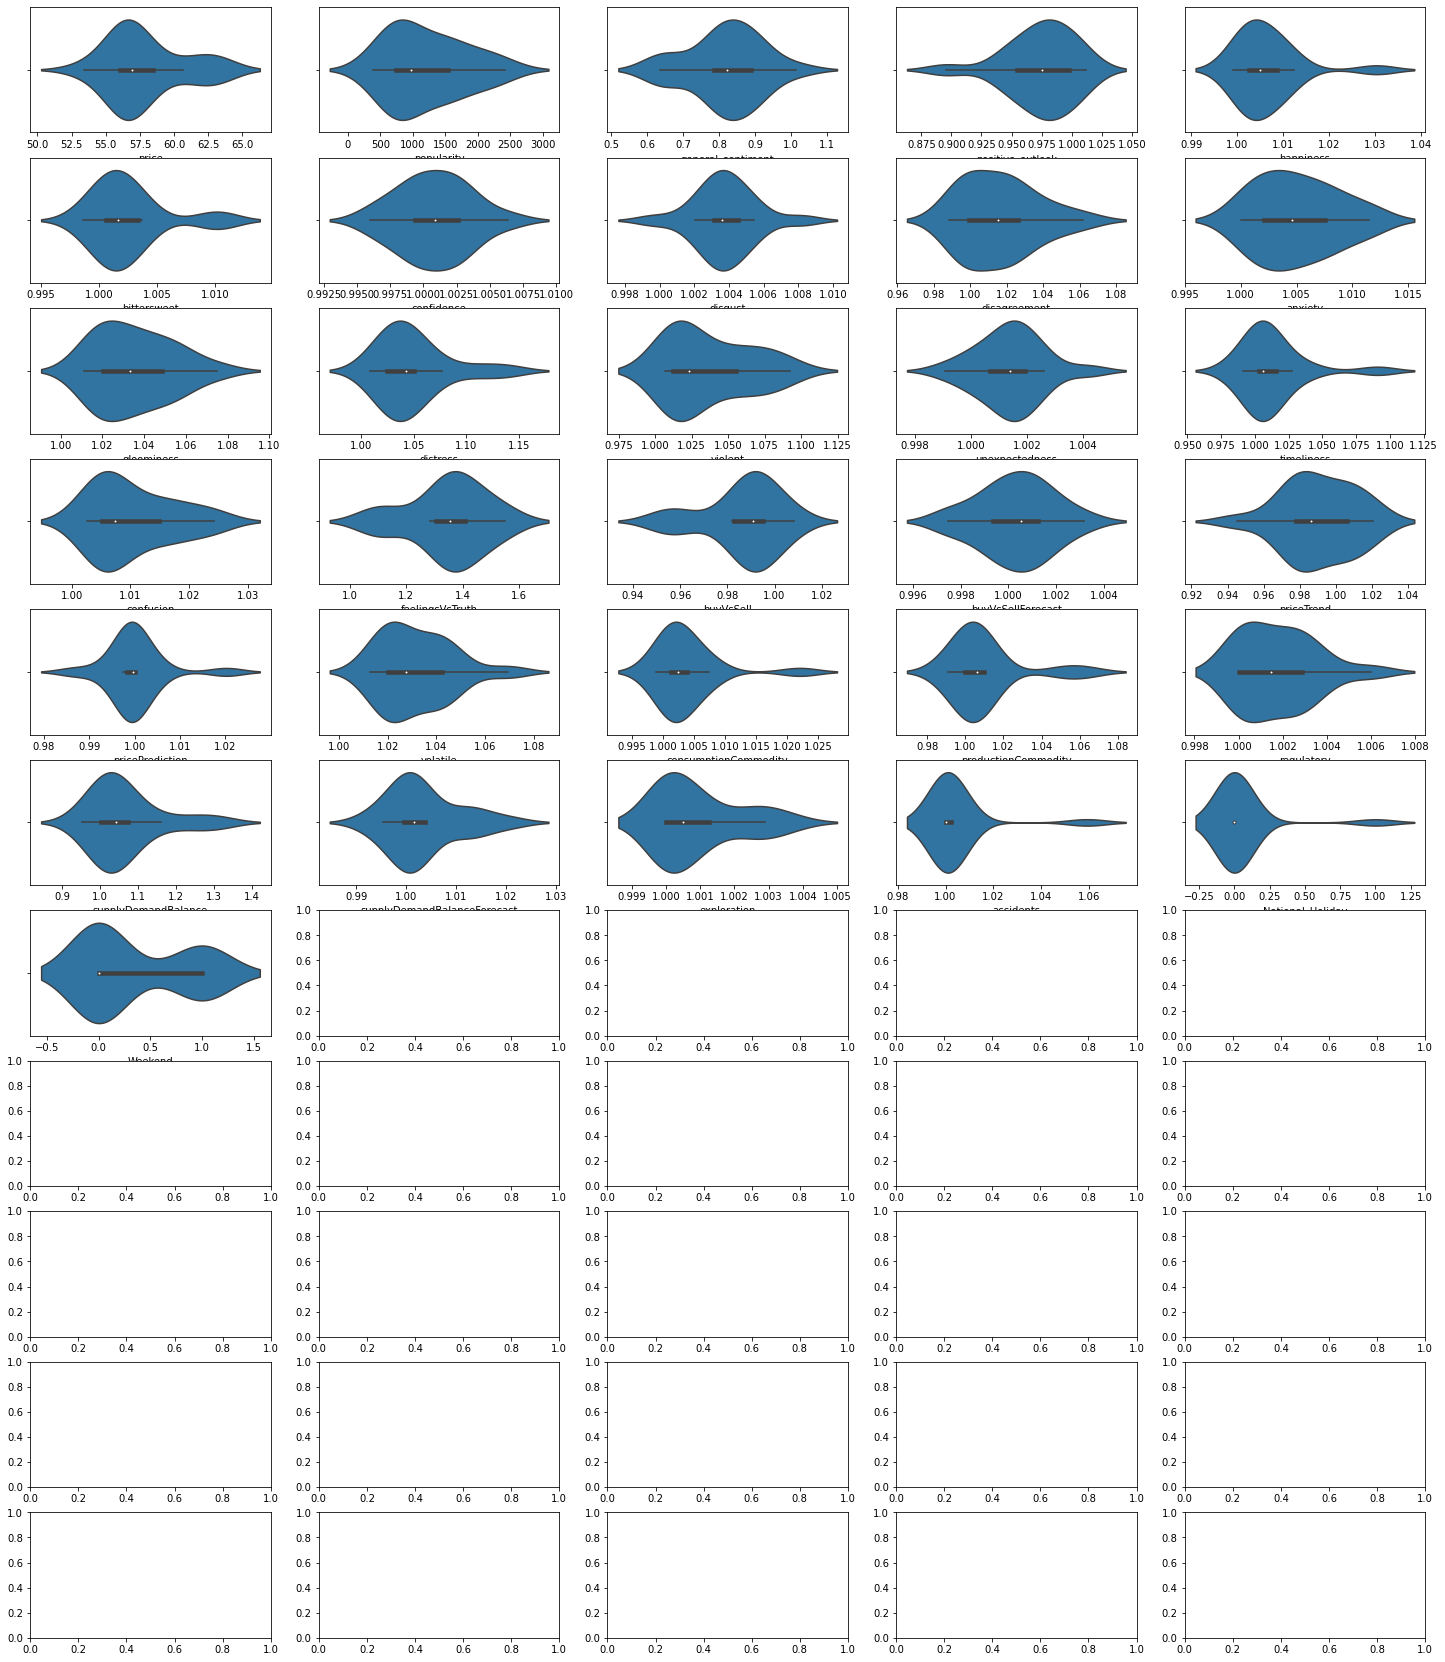

In [44]:
columnsNo = len(df_7sub.columns) / 5
rows = math.ceil(columnsNo)

fig, ax = plt.subplots(ncols = 5, nrows = rows, figsize = (25,30))
ax = ax.flatten()

for i, var in enumerate(df_7sub.iloc[:, df_7sub.columns != 'Date'].iteritems()):
    print(var[0])
    sns.violinplot(data= df_7sub, x = var[1], ax = ax[i])

plt.show()

## Feature Engineering

### Derive Features from the Date

In [ ]:
df_7_date = df_7['Date']
df_7_date = pd.DatetimeIndex(df_7_date).to_period('D')
#month one hot encoding
df_7['month'] = df_7_date.month
month_dummies = pd.get_dummies(df_7['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df_7 = pd.concat([df_7, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df_7['dayofweek'] = df_7_date.weekday
week_dummies = pd.get_dummies(df_7['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df_7 = pd.concat([df_7, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df_7['weekend'] = (df_7_date.dayofweek>4).astype(int)#Saturday,Sunday
#Sunday
df_7['sunday'] = (df_7_date.dayofweek==6).astype(int)#Saturday,Sunday

In [ ]:
df_30_date = df_30['Date']
df_30_date = pd.DatetimeIndex(df_30_date).to_period('D')
#month one hot encoding
df_30['month'] = df_30_date.month
month_dummies = pd.get_dummies(df_30['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df_30 = pd.concat([df_30, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df_30['dayofweek'] = df_30_date.weekday
week_dummies = pd.get_dummies(df_30['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df_30 = pd.concat([df_30, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df_30['weekend'] = (df_30_date.dayofweek>4).astype(int)#Saturday,Sunday
#Sunday
df_30['sunday'] = (df_30_date.dayofweek==6).astype(int)#Saturday,Sunday

In [ ]:
df_365_date = df_365['Date']
df_365_date = pd.DatetimeIndex(df_365_date).to_period('D')
#month one hot encoding
df_365['month'] = df_365_date.month
month_dummies = pd.get_dummies(df_365['month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
df_365 = pd.concat([df_365, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
df_365['dayofweek'] = df_365_date.weekday
week_dummies = pd.get_dummies(df_365['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
df_365 = pd.concat([df_365, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#Satday,Sunday
df_365['weekend'] = (df_365_date.dayofweek>4).astype(int)#Saturday,Sunday
#Sunday
df_365['sunday'] = (df_365_date.dayofweek==6).astype(int)#Saturday,Sunday

In [ ]:
df_365

,Date,price,popularity,general_sentiment,positive_outlook,happiness,bittersweet,confidence,disgust,disagreement,...,month-12,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,weekend,sunday
0,2010-01-01,87.240684,512.0,0.725496,0.954908,1.003136,1.002489,1.002457,1.019614,1.049026,...,0,0,0,0,0,1,0,0,0,0
1,2010-01-02,87.240684,290.4,0.925469,0.942806,1.017355,0.996551,0.990483,1.017355,0.979214,...,0,0,0,0,0,0,1,0,1,0
2,2010-01-03,87.240684,230.9,0.860199,0.971601,1.008735,0.991261,0.999452,1.008735,1.061160,...,0,0,0,0,0,0,0,1,1,1
3,2010-01-04,87.240684,1261.1,0.959104,0.963869,1.002389,1.000800,1.002389,1.002786,1.011522,...,0,1,0,0,0,0,0,0,0,0
4,2010-01-05,88.983266,1902.5,0.994995,0.964214,1.004993,1.002625,0.999205,1.002099,1.008676,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,2018-12-27,55.956283,2051.8,0.876848,0.978322,1.004910,1.000031,1.004178,1.002470,1.013447,...,1,0,0,0,1,0,0,0,0,0
3283,2018-12-28,56.043514,1519.5,0.905116,0.974309,1.008576,1.001986,1.002810,0.999680,1.000009,...,1,0,0,0,0,1,0,0,0,0
3284,2018-12-29,56.043514,972.6,0.766644,0.951581,1.005672,1.001905,1.003225,1.002066,0.995369,...,1,0,0,0,0,0,1,0,1,0
3285,2018-12-30,56.043514,737.4,0.655314,0.980987,1.005463,1.001913,1.002064,1.008183,0.988466,...,1,0,0,0,0,0,0,1,1,1


### Lagged Price (7 days)

In [ ]:
def create_lagged_features(df, col, lag_number = 1):
    
    df[col+"_lag_{}".format(lag_number)] = df[col].shift(lag_number)
    
    return(df)

In [ ]:
df_7 = create_lagged_features(df_7, 'price', 7)
df_30 = create_lagged_features(df_30, 'price', 7)
df_365 = create_lagged_features(df_365, 'price', 7)

### Rolling mean

In [ ]:
df_7['price_rm'] = df_7['price'].rolling(window = 7).mean()
df_30['price_rm'] = df_30['price'].rolling(window = 7).mean()
df_365['price_rm'] = df_365['price'].rolling(window = 7).mean()

### Expanding window (mean)

In [ ]:
df_7['price_ewm'] = df_7['price'].ewm(span = 7, adjust = False).mean()
df_30['price_ewm'] = df_30['price'].ewm(span = 7, adjust = False).mean()
df_365['price_ewm'] = df_365['price'].ewm(span = 7, adjust = False).mean()

## Output pre-processed data to excel file 

In [ ]:
df_7.to_excel("../Data/gasoline_price_sentiment_pre-processed_7.xlsx", "Sheet1")
df_30.to_excel("../Data/gasoline_price_sentiment_pre-processed_30.xlsx", "Sheet1")
df_365.to_excel("../Data/gasoline_price_sentiment_pre-processed_365.xlsx", "Sheet1")